In [1]:
import os
import imageio
import numpy as np
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import cv2
import shutil
tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
class Helpers():
    
    @staticmethod
    def normalize(images):
        return np.array(images)/127.5-1.0
    
    @staticmethod
    def unnormalize(images):
        return (0.5*np.array(images)+0.5)*255
    
    @staticmethod
    def resize(image, size):
        return np.array(cv2.resize(image, size))
    
    @staticmethod
    def split_images(image, is_testing):
        image = imageio.imread(image).astype(np.float)
        _, width, _ = image.shape
        half_width = int(width/2)
        source_image = image[:, half_width:, :]
        destination_image = image[:, :half_width, :]
        source_image = Helpers.resize(source_image, (IMAGE_SIZE, IMAGE_SIZE))
        destination_image = Helpers.resize(destination_image, (IMAGE_SIZE, IMAGE_SIZE))
        if not is_testing and np.random.random() > 0.5:
            source_image = np.fliplr(source_image)
            destination_image = np.fliplr(destination_image)
        return source_image, destination_image
    
    @staticmethod
    def new_dir(path):
        shutil.rmtree(path, ignore_errors=True)
        os.makedirs(path, exist_ok=True)
        
    @staticmethod
    def archive_output():
        shutil.make_archive("output", "zip", "./output")
        
    @staticmethod
    def image_pairs(batch, is_testing):
        source_images, destination_images = [], []
        for image_path in batch:
            source_image, destination_image = Helpers.split_images(image_path, is_testing)
            source_images.append(source_image)
            destination_images.append(destination_image)
        return source_images, destination_images

In [3]:
# Requires following dataset structure:
# dataset_name
# └── dataset_name
#     ├── testing
#     │   └── ... (image files)
#     ├── testing_raw
#     │   ├── ... (image files)
#     ├── training
#     │   └── ... (image files)
#     └── validation (optional)
#         └── ... (image files)
class DataLoader():
    
    def __init__(self, dataset_name="pix2pix-depth"):
        self.dataset_name = dataset_name
        base_path = BASE_INPUT_PATH + self.dataset_name + "/" + self.dataset_name + "/"
        self.training_path = base_path + "training/"
        self.validation_path = base_path + "validation/"
        self.testing_path = base_path + "testing/"
        self.testing_raw_path = base_path + "testing_raw/"

    def load_random_data(self, data_size, is_testing=False):
        paths = glob(self.training_path+"*") if is_testing else glob(self.testing_path+"*")
        source_images, destination_images = Helpers.image_pairs(np.random.choice(paths, size=data_size), is_testing)
        return Helpers.normalize(source_images), Helpers.normalize(destination_images)

    def yield_batch(self, batch_size, is_testing=False):
        paths = glob(self.training_path+"*") if is_testing else glob(self.validation_path+"*")
        for i in range(int(len(paths)/batch_size)-1):
            batch = paths[i*batch_size:(i+1)*batch_size]
            source_images, destination_images = Helpers.image_pairs(batch, is_testing)
            yield Helpers.normalize(source_images), Helpers.normalize(destination_images)

In [4]:
# Model architecture from: https://phillipi.github.io/pix2pix/
class Pix2Pix(): 
    
    def __init__(self):
        Helpers.new_dir(BASE_OUTPUT_PATH + "training/")
        Helpers.new_dir(BASE_OUTPUT_PATH + "training/losses/")

        self.image_shape = (IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)
        self.data_loader = DataLoader()

        patch = int(IMAGE_SIZE / 2**4)
        self.disc_patch = (patch, patch, 1)

        self.generator_filters = 64
        self.discriminator_filters = 64
        
        optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, BETA_1)

        self.discriminator = self.discriminator()
        self.discriminator.compile(loss="mse", optimizer=optimizer, metrics=["accuracy"])
        self.generator = self.generator()

        source_image = tf.keras.layers.Input(shape=self.image_shape)
        destination_image = tf.keras.layers.Input(shape=self.image_shape)
        generated_image = self.generator(destination_image)

        self.discriminator.trainable = False
        valid = self.discriminator([generated_image, destination_image])
        self.combined = tf.keras.models.Model(inputs=[source_image, destination_image], outputs=[valid, generated_image])
        self.combined.compile(loss=["mse", "mae"], loss_weights=[1, 100], optimizer=optimizer)

    def generator(self):
        def conv2d(layer_input, filters, bn=True):
            downsample = tf.keras.layers.Conv2D(filters, kernel_size=4, strides=2, padding="same")(layer_input)
            downsample = tf.keras.layers.LeakyReLU(alpha=LEAKY_RELU_ALPHA)(downsample)
            if bn:
                downsample = tf.keras.layers.BatchNormalization(momentum=BN_MOMENTUM)(downsample)
            return downsample

        def deconv2d(layer_input, skip_input, filters, dropout_rate=0):
            upsample = tf.keras.layers.UpSampling2D(size=2)(layer_input)
            upsample = tf.keras.layers.Conv2D(filters, kernel_size=4, strides=1, padding="same", activation="relu")(upsample)
            if dropout_rate:
                upsample = tf.keras.layers.Dropout(dropout_rate)(upsample)
            upsample = tf.keras.layers.BatchNormalization(momentum=BN_MOMENTUM)(upsample)
            upsample = tf.keras.layers.Concatenate()([upsample, skip_input])
            return upsample

        downsample_0 = tf.keras.layers.Input(shape=self.image_shape)
        downsample_1 = conv2d(downsample_0, self.generator_filters, bn=False)
        downsample_2 = conv2d(downsample_1, self.generator_filters*2)
        downsample_3 = conv2d(downsample_2, self.generator_filters*4)
        downsample_4 = conv2d(downsample_3, self.generator_filters*8)
        downsample_5 = conv2d(downsample_4, self.generator_filters*8)
        downsample_6 = conv2d(downsample_5, self.generator_filters*8)
        downsample_7 = conv2d(downsample_6, self.generator_filters*8)

        upsample_1 = deconv2d(downsample_7, downsample_6, self.generator_filters*8)
        upsample_2 = deconv2d(upsample_1, downsample_5, self.generator_filters*8)
        upsample_3 = deconv2d(upsample_2, downsample_4, self.generator_filters*8)
        upsample_4 = deconv2d(upsample_3, downsample_3, self.generator_filters*4)
        upsample_5 = deconv2d(upsample_4, downsample_2, self.generator_filters*2)
        upsample_6 = deconv2d(upsample_5, downsample_1, self.generator_filters)
        upsample_7 = tf.keras.layers.UpSampling2D(size=2)(upsample_6)
        
        output_image = tf.keras.layers.Conv2D(IMAGE_CHANNELS, kernel_size=4, strides=1, padding="same", activation="tanh")(upsample_7)
        return tf.keras.models.Model(downsample_0, output_image)

    def discriminator(self):
        def discriminator_layer(layer_input, filters, bn=True):
            discriminator_layer = tf.keras.layers.Conv2D(filters, kernel_size=4, strides=2, padding="same")(layer_input)
            discriminator_layer = tf.keras.layers.LeakyReLU(alpha=LEAKY_RELU_ALPHA)(discriminator_layer)
            if bn:
                discriminator_layer = tf.keras.layers.BatchNormalization(momentum=BN_MOMENTUM)(discriminator_layer)
            return discriminator_layer

        source_image = tf.keras.layers.Input(shape=self.image_shape)
        destination_image = tf.keras.layers.Input(shape=self.image_shape)
        combined_images = tf.keras.layers.Concatenate(axis=-1)([source_image, destination_image])
        discriminator_layer_1 = discriminator_layer(combined_images, self.discriminator_filters, bn=False)
        discriminator_layer_2 = discriminator_layer(discriminator_layer_1, self.discriminator_filters*2)
        discriminator_layer_3 = discriminator_layer(discriminator_layer_2, self.discriminator_filters*4)
        discriminator_layer_4 = discriminator_layer(discriminator_layer_3, self.discriminator_filters*8)
        validity = tf.keras.layers.Conv2D(1, kernel_size=4, strides=1, padding="same")(discriminator_layer_4)
        return tf.keras.models.Model([source_image, destination_image], validity)
        
    def preview_training_progress(self, epoch, size=3):
        def preview_outputs(epoch, size):
            source_images, destination_images = self.data_loader.load_random_data(size, is_testing=True)
            generated_images = self.generator.predict(destination_images)
            grid_image = None
            for i in range(size):
                row = Helpers.unnormalize(np.concatenate([destination_images[i], generated_images[i], source_images[i]], axis=1))
                if grid_image is None:
                    grid_image = row
                else:
                    grid_image = np.concatenate([grid_image, row], axis=0)
            plt.imshow(grid_image/255.0)
            plt.show()
            plt.close()
            grid_image = cv2.cvtColor(np.float32(grid_image), cv2.COLOR_RGB2BGR)
            cv2.imwrite(BASE_OUTPUT_PATH + "training/ " + str(epoch) + ".png", grid_image)
            
        def preview_losses():
            def plot(title, data):
                plt.plot(data, alpha=0.6)
                plt.title(title + "_" + str(i))
                plt.savefig(BASE_OUTPUT_PATH + "training/losses/" + title + "_" + str(i) + ".png")
                plt.close()
            for i, d in enumerate(self.d_losses):
                plot("discriminator", d)
            for i, g in enumerate(self.g_losses):
                plot("generator", g)
                
        preview_outputs(epoch, size)
        #preview_losses()

    def train(self):
        valid = np.ones((BATCH_SIZE,) + self.disc_patch)
        fake = np.zeros((BATCH_SIZE,) + self.disc_patch)
        self.d_losses = []
        self.g_losses = []
        self.preview_training_progress(0)
        for epoch in range(EPOCHS):
            epoch_d_losses = []
            epoch_g_losses = []
            for iteration, (source_images, destination_images) in enumerate(self.data_loader.yield_batch(BATCH_SIZE)):
                generated_images = self.generator.predict(destination_images)
                d_loss_real = self.discriminator.train_on_batch([source_images, destination_images], valid)
                d_loss_fake = self.discriminator.train_on_batch([generated_images, destination_images], fake)
                d_losses = 0.5 * np.add(d_loss_real, d_loss_fake)
                g_losses = self.combined.train_on_batch([source_images, destination_images], [valid, source_images])
                epoch_d_losses.append(d_losses)
                epoch_g_losses.append(g_losses)
                print("\repoch: " + str(epoch) 
                      +", iteration: "+ str(iteration) 
                      + ", d_losses: " + str(d_losses) 
                      + ", g_losses: " + str(g_losses)
                      , sep=" ", end=" ", flush=True)
            self.d_losses.append(np.average(epoch_d_losses, axis=0))
            self.g_losses.append(np.average(epoch_g_losses, axis=0))
            self.preview_training_progress(epoch)
        
    def test(self):
        image_paths = glob(self.data_loader.testing_raw_path+"*")
        for image_path in image_paths:
            image = np.array(imageio.imread(image_path))
            image_normalized = Helpers.normalize(image)
            generated_batch = self.generator.predict(np.array([image_normalized]))
            concat = Helpers.unnormalize(np.concatenate([image_normalized, generated_batch[0]], axis=1))
            cv2.imwrite(BASE_OUTPUT_PATH+os.path.basename(image_path), cv2.cvtColor(np.float32(concat), cv2.COLOR_RGB2BGR))
            

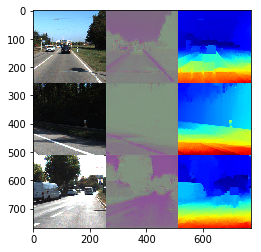

epoch: 0, iteration: 24, d_losses: [0.43664965 0.47790527], g_losses: [30.702988, 0.49852687, 0.3020446]  

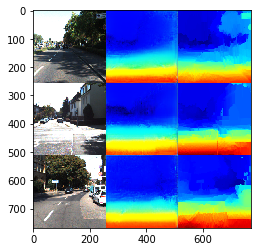

epoch: 1, iteration: 24, d_losses: [0.36116248 0.5040283 ], g_losses: [28.501324, 0.4493761, 0.2805195] ] 

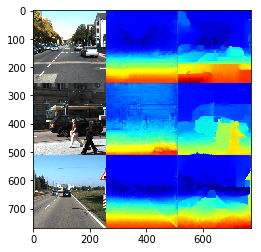

epoch: 2, iteration: 24, d_losses: [0.35240746 0.5145874 ], g_losses: [26.615652, 0.39246404, 0.2622319]  

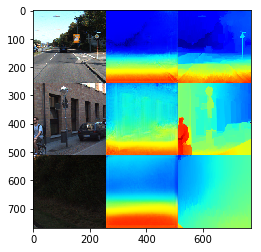

epoch: 3, iteration: 24, d_losses: [0.3028298  0.51989746], g_losses: [25.54665, 0.37260348, 0.25174046]  

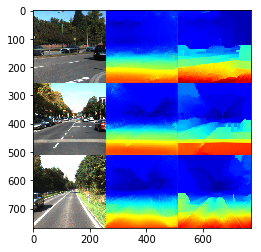

epoch: 4, iteration: 24, d_losses: [0.35792327 0.47045898], g_losses: [24.34078, 0.3791309, 0.2396165] 2] 

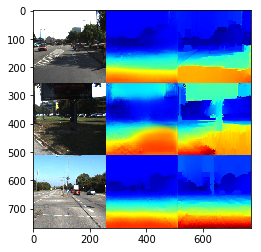

epoch: 5, iteration: 24, d_losses: [0.31161883 0.5209961 ], g_losses: [23.20929, 0.353011, 0.2285628] 37] 

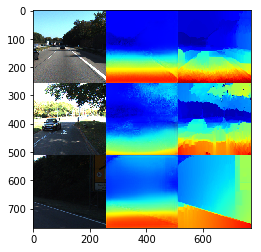

epoch: 6, iteration: 24, d_losses: [0.27384043 0.5073242 ], g_losses: [22.844532, 0.33068797, 0.22513843] 

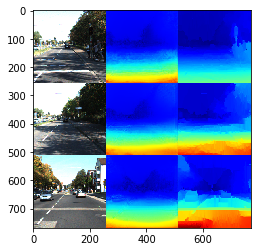

epoch: 7, iteration: 24, d_losses: [0.29038894 0.48913574], g_losses: [21.258417, 0.3742332, 0.20884183]  

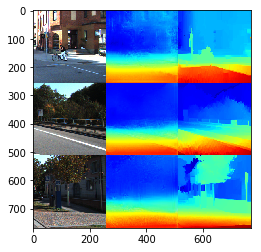

epoch: 8, iteration: 24, d_losses: [0.33564657 0.47332764], g_losses: [21.071545, 0.43730298, 0.20634241] 

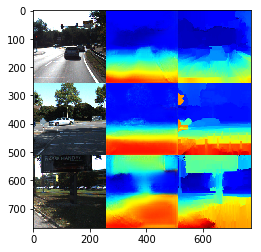

epoch: 9, iteration: 24, d_losses: [0.2978533 0.5315552], g_losses: [20.482283, 0.33993998, 0.20142344] ] 

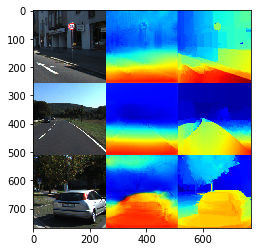

epoch: 10, iteration: 24, d_losses: [0.31098253 0.51257324], g_losses: [20.167025, 0.3242734, 0.19842751]  

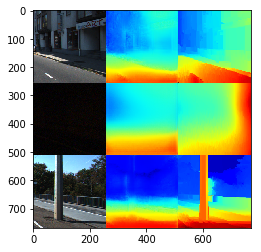

epoch: 11, iteration: 24, d_losses: [0.27021754 0.5286255 ], g_losses: [18.601341, 0.30721804, 0.18294123] 

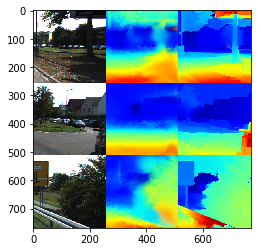

epoch: 12, iteration: 24, d_losses: [0.26536316 0.5026245 ], g_losses: [18.598043, 0.3059031, 0.18292141]  

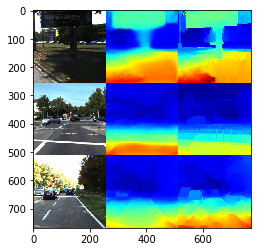

epoch: 13, iteration: 24, d_losses: [0.2654128 0.5299072], g_losses: [17.397379, 0.31474036, 0.17082638] ] 

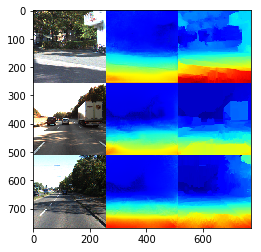

epoch: 14, iteration: 24, d_losses: [0.25975752 0.53985596], g_losses: [18.104523, 0.33281505, 0.17771707] 

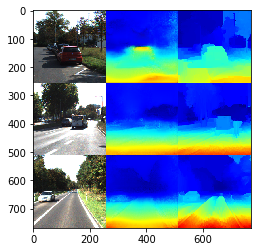

epoch: 15, iteration: 24, d_losses: [0.29959354 0.5340576 ], g_losses: [17.253345, 0.45293912, 0.16800405] 

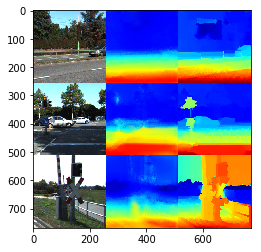

epoch: 16, iteration: 24, d_losses: [0.23856537 0.63549805], g_losses: [16.083338, 0.38399345, 0.15699343] 

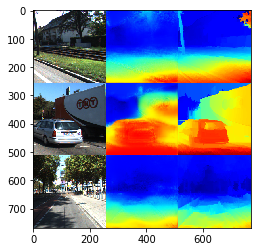

epoch: 17, iteration: 24, d_losses: [0.21862155 0.6732178 ], g_losses: [15.902269, 0.4426795, 0.1545959]   

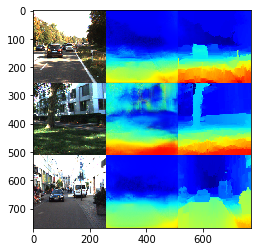

epoch: 18, iteration: 24, d_losses: [0.20138012 0.7119751 ], g_losses: [14.724116, 0.5310875, 0.14193028]  

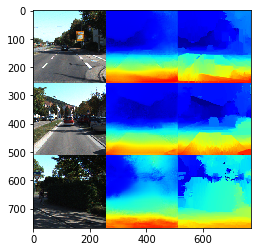

epoch: 19, iteration: 24, d_losses: [0.14521685 0.8347168 ], g_losses: [14.894897, 0.5807729, 0.14314124]   

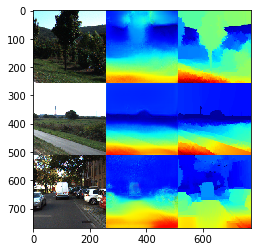

epoch: 20, iteration: 24, d_losses: [0.20202103 0.7279053 ], g_losses: [14.033532, 0.52516615, 0.13508366] 

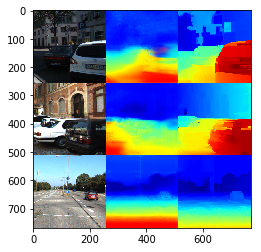

epoch: 21, iteration: 24, d_losses: [0.27811992 0.50109863], g_losses: [14.767888, 0.38270125, 0.14385188]  

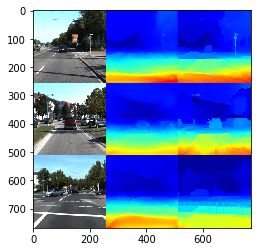

epoch: 22, iteration: 24, d_losses: [0.28591865 0.42980957], g_losses: [14.754412, 0.3625211, 0.1439189] 2] 

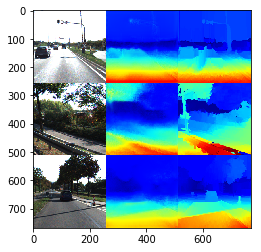

epoch: 23, iteration: 24, d_losses: [0.24170166 0.58862305], g_losses: [12.676835, 0.44790208, 0.12228934]  

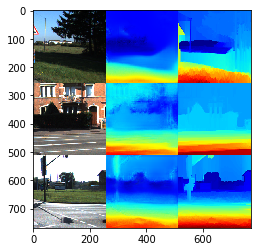

epoch: 24, iteration: 24, d_losses: [0.20826778 0.70806885], g_losses: [12.703922, 0.6386342, 0.120652884] 

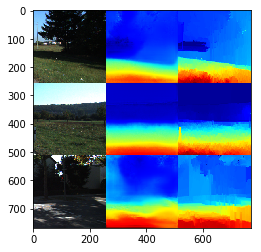

epoch: 25, iteration: 24, d_losses: [0.2002789  0.72857666], g_losses: [12.0171175, 0.5175176, 0.11499599]  

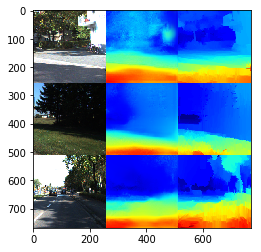

epoch: 26, iteration: 24, d_losses: [0.21313304 0.65625   ], g_losses: [12.114883, 0.4277335, 0.1168715]   

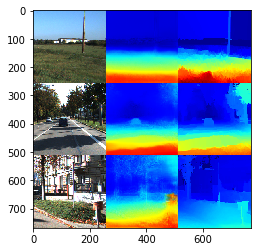

epoch: 27, iteration: 24, d_losses: [0.22386172 0.6524048 ], g_losses: [11.975987, 0.4852049, 0.11490783] ] 

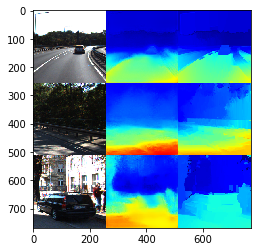

epoch: 28, iteration: 24, d_losses: [0.1840288  0.77038574], g_losses: [12.2374, 0.51305735, 0.117243424]   

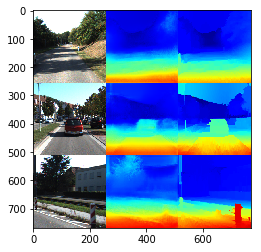

epoch: 29, iteration: 24, d_losses: [0.22377837 0.62994385], g_losses: [11.214179, 0.3963873, 0.108177915]  

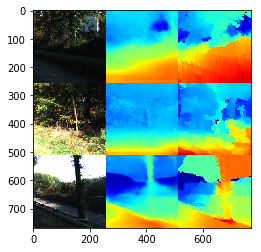

epoch: 30, iteration: 24, d_losses: [0.24164207 0.58758545], g_losses: [11.2088, 0.34974748, 0.10859053]  ] 

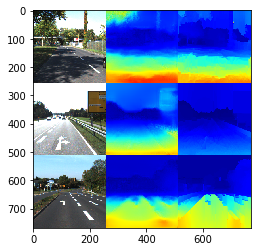

epoch: 31, iteration: 24, d_losses: [0.23474672 0.5749512 ], g_losses: [10.906238, 0.35037526, 0.10555863]  

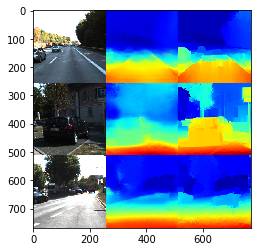

epoch: 32, iteration: 24, d_losses: [0.24448472 0.5984497 ], g_losses: [10.588384, 0.32102925, 0.10267354]  

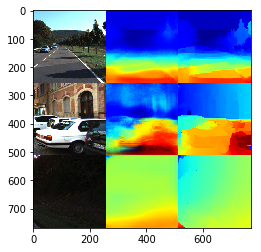

epoch: 33, iteration: 24, d_losses: [0.2644351 0.5161133], g_losses: [10.69964, 0.2918393, 0.104078] 87]   

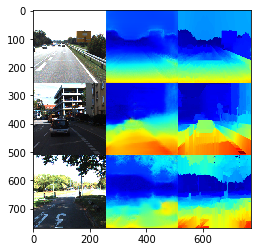

epoch: 34, iteration: 24, d_losses: [0.2627387 0.5314331], g_losses: [10.320192, 0.27513617, 0.10045056]   

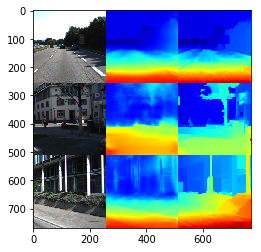

epoch: 35, iteration: 24, d_losses: [0.26473886 0.538208  ], g_losses: [10.312333, 0.30818003, 0.10004153] 

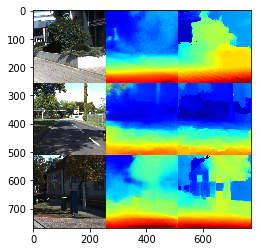

epoch: 36, iteration: 24, d_losses: [0.25195414 0.55963135], g_losses: [10.008884, 0.37968737, 0.09629197] 

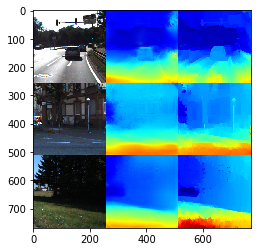

epoch: 37, iteration: 24, d_losses: [0.26956815 0.49456787], g_losses: [10.013411, 0.31238195, 0.09701029]  

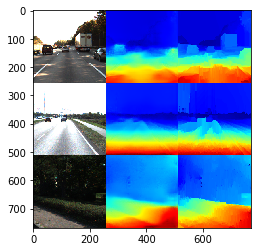

epoch: 38, iteration: 24, d_losses: [0.28768933 0.43988037], g_losses: [9.485249, 0.2377548, 0.09247494] ]  

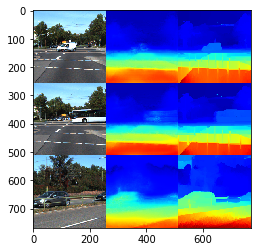

epoch: 39, iteration: 24, d_losses: [0.29093152 0.4284668 ], g_losses: [9.449138, 0.22824241, 0.092208944] 

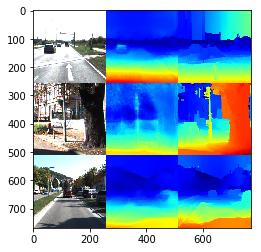

epoch: 40, iteration: 24, d_losses: [0.27139473 0.4354248 ], g_losses: [9.1341, 0.28242707, 0.08851673] ]  

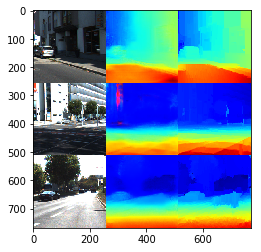

epoch: 41, iteration: 24, d_losses: [0.27683166 0.42962646], g_losses: [9.111637, 0.2702965, 0.08841341]   

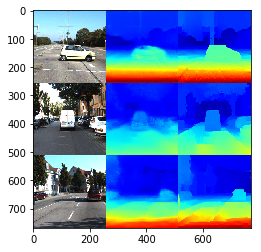

epoch: 42, iteration: 24, d_losses: [0.27358106 0.47088623], g_losses: [9.187675, 0.23730713, 0.089503676]  

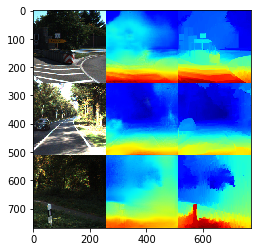

epoch: 43, iteration: 24, d_losses: [0.26874247 0.46704102], g_losses: [8.772997, 0.22491966, 0.08548078]  

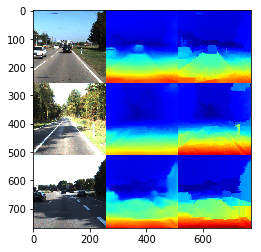

epoch: 44, iteration: 24, d_losses: [0.26236215 0.51452637], g_losses: [8.389062, 0.25179973, 0.08137262]  

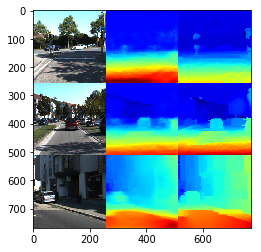

epoch: 45, iteration: 24, d_losses: [0.24334422 0.590271  ], g_losses: [8.528906, 0.28083733, 0.08248069]  

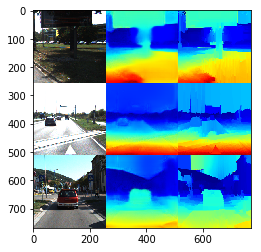

epoch: 46, iteration: 24, d_losses: [0.2841313 0.4515381], g_losses: [8.397118, 0.25025403, 0.08146864] ] ] 

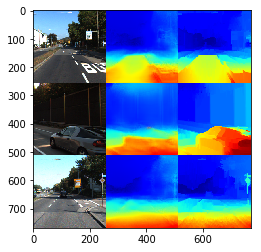

epoch: 47, iteration: 24, d_losses: [0.2656308  0.51690674], g_losses: [8.874985, 0.2973076, 0.08577677]   

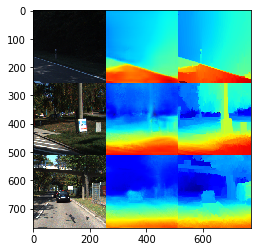

epoch: 48, iteration: 24, d_losses: [0.24448858 0.6171875 ], g_losses: [8.161783, 0.31373036, 0.07848053]  

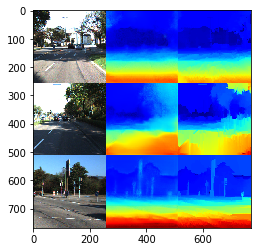

epoch: 49, iteration: 24, d_losses: [0.26466894 0.5183716 ], g_losses: [8.173591, 0.2871193, 0.078864716]   

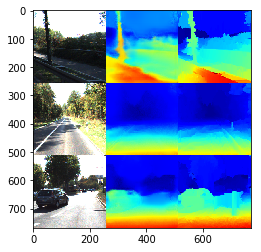

In [5]:
BASE_INPUT_PATH = "../input/pix2pix-depth/" 
BASE_OUTPUT_PATH = "./output/"

IMAGE_SIZE = 256
IMAGE_CHANNELS = 3
LEARNING_RATE = 0.00015
BETA_1 = 0.5
LEAKY_RELU_ALPHA = 0.2
BN_MOMENTUM = 0.8
EPOCHS = 50
BATCH_SIZE = 32

gan = Pix2Pix()
gan.train()
gan.test()
Helpers.archive_output()